In [1]:
import xgboost as xgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from xgboost import plot_importance
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from Utils import load_parameters

In [2]:
params = load_parameters('config.yaml')
input_file_path = Path(params['root_path']) / r"4_Cleansed_data\cleansed.csv"
df_cl = pd.read_csv(input_file_path, sep=';')

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 5)

In [4]:
params = load_parameters('config.yaml')
input_file_path = Path(params['root_path']) / r"5_Adjusted_data\adjusted.csv"

df = pd.read_csv(input_file_path, sep=';')
cols = [
    'price',
    'mileage',
    'wheels',
    'power',
    'version',
    'is_gearbox_automatic',
    'ASO_serviced',
    'is_car_new',
    'color_Bezowy',
    'color_Biay',
    'color_Czarny',
    'color_Czerwony',
    'color_Inny_kolor',
    'color_Niebieski',
    'color_Pomaranczowy',
    'color_Srebrny',
    'color_Szary'
]
df = df[cols]
X = df.drop('price', axis=1)
y = df['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Create and train XGBoost model
model = xgb.XGBRegressor(objective ='reg:squarederror')
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

In [6]:
# Evaluate
mse = mean_squared_error(y_test, y_pred)
print(f"SMSE: {mse**0.5}")

SMSE: 7562.793247301261


In [ ]:
#full SMSE: 10254.549813245034
#damaged cars removed: 7072.793322915781

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

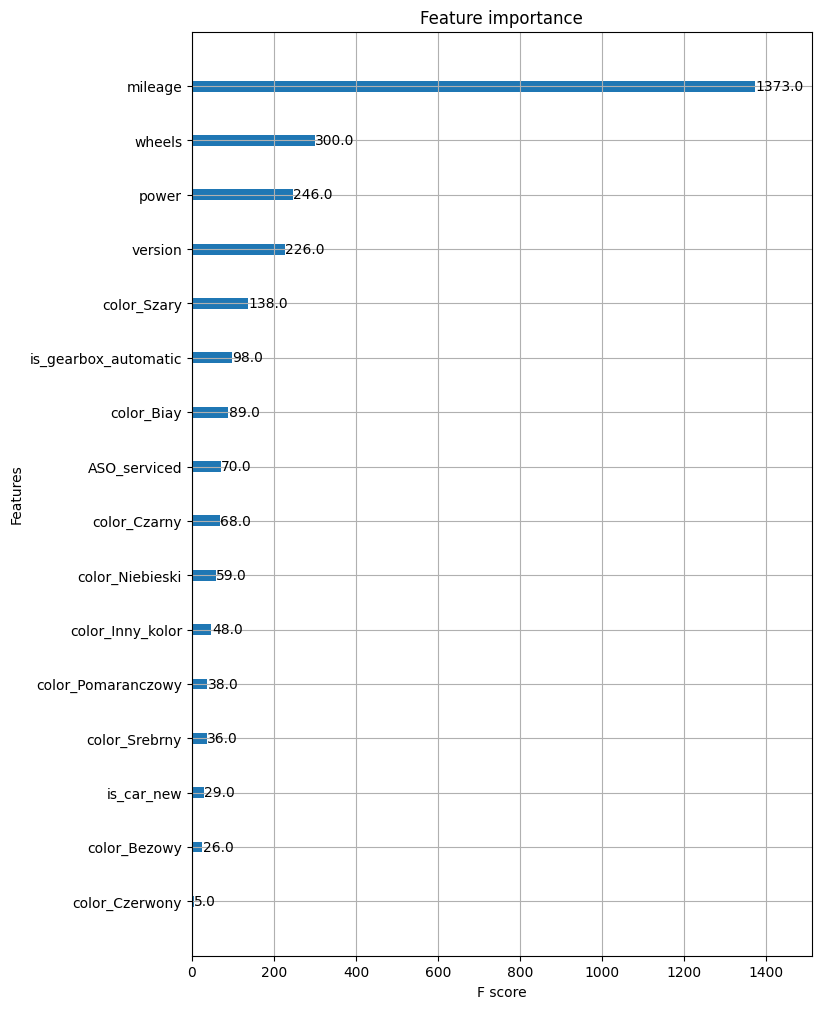

In [8]:
plt.rcParams['figure.figsize'] = [8, 12] 
plot_importance(model)

[18:29:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


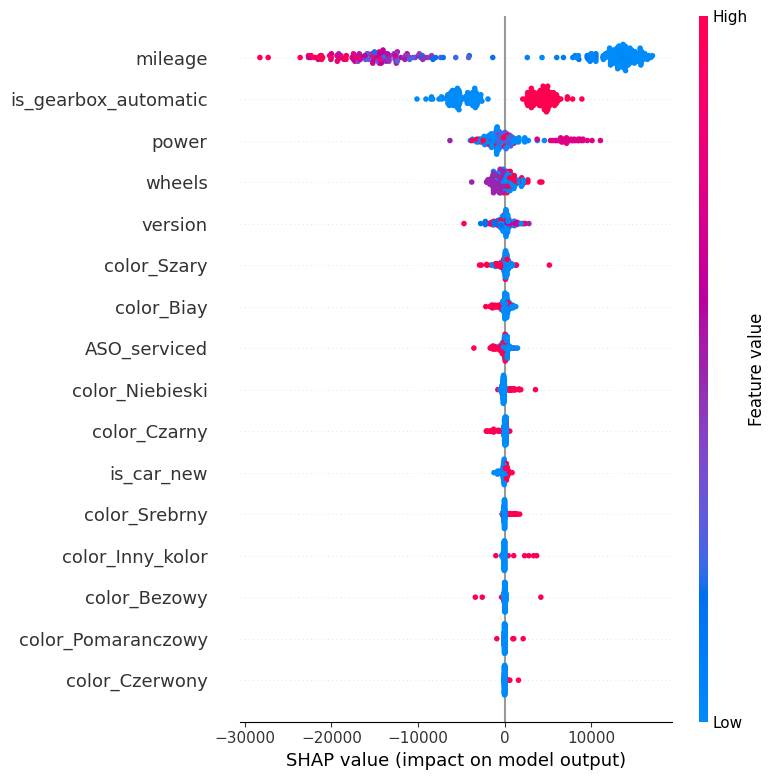

In [7]:
# Load JS visualization code to notebook
#shap.initjs()

# Assuming 'model' is your trained XGBoost model and X is your input features
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Visualize the first prediction's explanation
shap.summary_plot(shap_values, X_train)

In [9]:
#compare prediction vs real test value row by row
df_test = pd.DataFrame(y_pred, columns=['price_pred'])
df_test['price_real'] = y_test.reset_index()['price']
df_test['index'] = y_test.reset_index()['index']
df_test['error'] = round(abs(df_test['price_pred'] - df_test['price_real']))
df_test['price_pred'] = round(df_test['price_pred'])
df_test = pd.merge(df_test, X_test.reset_index(), on='index', how='inner')
df_test = df_test.sort_values('error').reset_index(drop=True)
df_test.drop(['index'], axis=1, inplace=True)

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


<Axes: ylabel='error'>

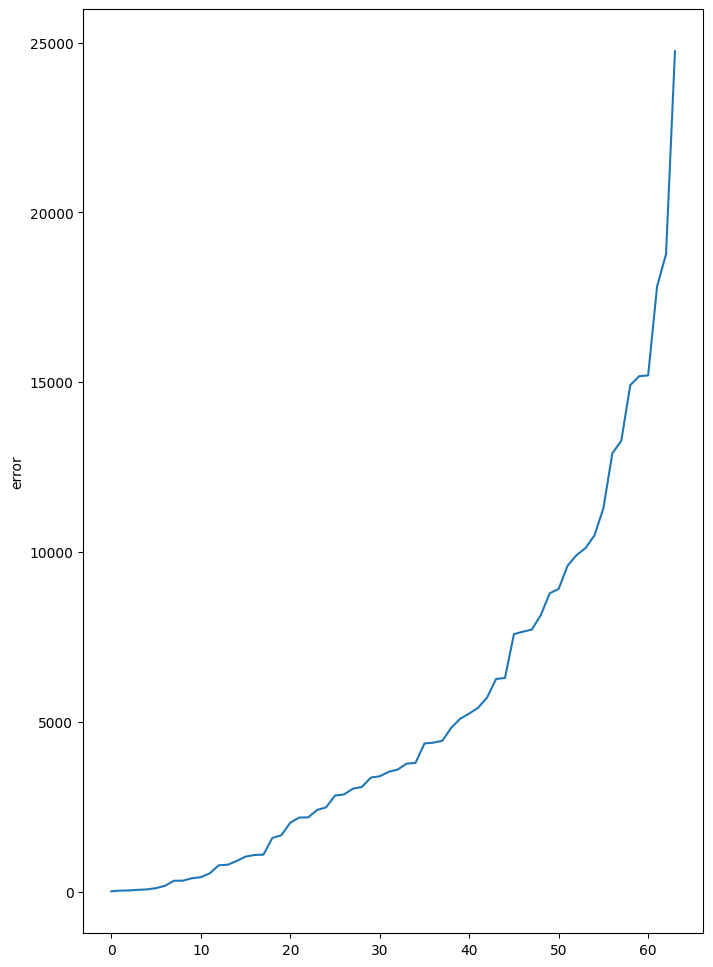

In [10]:
sns.lineplot(data=df_test['error'])